
<a id='mccall-with-sep'></a>
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# Pesquisa de Emprego II: Pesquisa e Separação


<a id='index-0'></a>

## Conteúdo

- [Pesquisa de Emprego II: Pesquisa e Separação](#Pesquisa-de-Emprego-II:-Pesquisa-e-Separação)  
  - [Resumo](#Resumo)  
  - [O Modelo](#O-Modelo)  
  - [Resolvendo o Modelo Usando Programação Dinâmica](#Resolvendo-o-Modelo-Usando-Programação-Dinâmica)  
  - [Implementação](#Implementação)  
  - [O Salário de Reserva](#O-Salário-de-Reserva)  
  - [Exercícios](#Exercícios)  
  - [Soluções](#Soluções)  

> *Devidamente traduzido, revisado e adaptado do [QuantEcon](https://quantecon.org/) pelos bolsistas CNPq, Pedro Luiz H. Furtado e Jonas Aragão M. Corpes, sob supervisão do Prof. Christiano Penna, do CAEN/UFC.*


## Resumo

Anteriormente [vimos](https://julia.quantecon.org/mccall_model.html) o modelo de pesquisa de emprego de McCall [[McC70]](https://julia.quantecon.org/../zreferences.html#mccall1970) como uma maneira de entender o desemprego e as decisões dos trabalhadores.

Uma característica irreal do modelo é que todo trabalho é permanente.

Nesta aula, estendemos o modelo McCall introduzindo a separação de tarefas.

Depois que a separação entra em cena, o agente passa a ver:

- a perda de um emprego como uma perda de capital, e  
- um período de desemprego como um *investimento* na busca de um emprego aceitável.

### Configuração

In [1]:
using InstantiateFromURL
github_project("QuantEcon/quantecon-notebooks-julia", version = "0.5.0")
# github_project("QuantEcon/quantecon-notebooks-julia", version = "0.5.0", instantiate = true) # uncomment to force package installation

In [2]:
using LinearAlgebra, Statistics
using Distributions, Expectations, Parameters, NLsolve, Plots

## O Modelo

O modelo diz respeito à vida de um trabalhador como vida infinita e,

- as oportunidades que ele ou ela (vamos dizer ele para manter um personagem) tem que trabalhar com diferentes salários. 
- eventos exógenos destroem seu emprego atual. 
- seu processo de tomada de decisão enquanto desempregado.


O trabalhador pode estar em um desses dois estados: empregado ou desempregado.

Ele quer maximizar:


<a id='equation-objective'></a>
$$
{\mathbb E} \sum_{t=0}^\infty \beta^t u(Y_t) \tag{1}
$$

A única diferença do [modelo básico](https://julia.quantecon.org/mccall_model.html) é que adicionamos alguma flexibilidade sobre as preferências, introduzindo uma função de utilidade $ u $.

E satisfaz $ u'> 0 $ e $ u'' < 0 $.

### *Timing* e Decisões

Aqui está o que acontece no início de um determinado período em nosso modelo, com pesquisa e separação.

Se atualmente *empregado*, o trabalhador consome seu salário $ w $, recebendo a utilidade $ u(w) $.

Se atualmente *desempregado*, ele:

- recebe e consome o seguro desemprego $ c $  
- recebe uma oferta para começar a trabalhar no *próximo período* com um salário $ w' $ extraido de uma distribuição conhecida $ p_1, \ldots, p_n $  


Ele pode aceitar ou rejeitar a oferta.

Se ele aceitar a oferta, ele entra no próximo período empregado com salário $ w' $.

Se ele rejeitar a oferta, ele entra no próximo período desempregado.

Quando empregado, o agente enfrenta uma probabilidade constante $ \alpha $ de ficar desempregado no final do período.

(Nota: não permitimos busca de emprego enquanto empregado - esse tópico será abordado em uma [aula posterior](https://julia.quantecon.org/jv.html))

## Resolvendo o Modelo Usando Programação Dinâmica

Seja:

- $ V(w) $ o valor total da vida útil acumulado para um trabalhador que entra no período atual *empregado* com salário $ w $.  
- $ U $ o valor total da vida útil acumulado para um trabalhador que está *desempregado* nesse período.  


Aqui *valor* significa o valor da função objetivo [(1)](#equation-objective) quando o trabalhador toma decisões ótimas em todos os momentos futuros.

Suponha, por enquanto, que o trabalhador possa calcular a função $ V $ e a constante $ U $ e usá-los em sua tomada de decisão.

Então $ V $ e $ U $ deve satisfazer:


<a id='equation-bell1-mccall'></a>
$$
V(w) = u(w) + \beta [(1-\alpha)V(w) + \alpha U ] \tag{2}
$$

and


<a id='equation-bell2-mccall'></a>
$$
U = u(c) + \beta \sum_i \max \left\{ U, V(w_i) \right\} p_i \tag{3}
$$

Vamos interpretar essas duas equações à luz do fato de que hoje amanhã é amanhã hoje.

- O lado esquerdo das equações [(2)](#equation-bell1-mccall) e [(3)](#equation-bell2-mccall)são os valores de um trabalhador em uma situação particular *hoje*.  
- Os lados direitos das equações são valores esperados descontados (por $ \beta $) das possíveis situações em que o trabalhador poderá estar *amanhã*.  
- Mas *amanhã* o trabalhador poderá estar em apenas uma das situações cujos valores *hoje* estão no lado esquerdo de nossas duas equações.  


A equação [(3)](#equation-bell2-mccall) incorpora o fato que um trabalhador atualmente desempregado irá maximizar seu próprio bem-estar.

Em particular, se sua oferta salarial no próximo período for $ w' $, ele escolherá permanecer desempregado, a menos que $ U < V(w') $.

As equações [(2)](#equation-bell1-mccall) e [(3)](#equation-bell2-mccall) são as Equações de Bellman para esse modelo.
As equações [(2)](#equation-bell1-mccall) e [(3)](#equation-bell2-mccall) fornecem informações suficientes para resolver os ambos $ V $ e $ U $.

Antes de discutir isso, no entanto, vamos fazer uma pequena extensão para o modelo.

### Ofertas Estocásticas

Vamos supor agora que os trabalhadores desempregados nem sempre recebem ofertas de emprego.

Em vez disso, vamos supor que os trabalhadores desempregados recebam apenas uma oferta com probabilidade $ \gamma $.

Se nosso trabalhador recebe uma oferta, a oferta salarial é retirada de $ p $ como antes.

Ele aceita ou rejeita a oferta.

Caso contrário, o modelo é o mesmo.

Com algum pensamento, você será capaz de se convencer de que $ V $ e $ U $ devem agora satisfazer:


<a id='equation-bell01-mccall'></a>
$$
V(w) = u(w) + \beta [(1-\alpha)V(w) + \alpha U ] \tag{4}
$$

                                                                   e


<a id='equation-bell02-mccall'></a>
$$
U = u(c) +
  \beta (1 - \gamma) U +
  \beta \gamma \sum_i \max \left\{ U, V(w_i) \right\} p_i \tag{5}
$$

### Resolvendo as Equações de Bellman

Usaremos a mesma abordagem iterativa para resolver as equações de Bellman que adotamos na [primeira aula de pesquisa de emprego](https://julia.quantecon.org/mccall_model.html).

Aqui isso equivale a:

1. faça suposições para $ U $ e $ V $.  
1. conecte essas suposições nos lados direito de [(4)](#equation-bell01-mccall) e [(5)](#equation-bell02-mccall).  
1. atualize os lados esquerdos desta regra e repita.  


Em outra palavras, estamos iterando usando as regras,


<a id='equation-bell1001'></a>
$$
V_{n+1} (w_i) = u(w_i) + \beta [(1-\alpha)V_n (w_i) + \alpha U_n ] \tag{6}
$$

e


<a id='equation-bell2001'></a>
$$
U_{n+1} = u(c) +
    \beta (1 - \gamma) U_n +
    \beta \gamma \sum_i \max \{ U_n, V_n(w_i) \} p_i \tag{7}
$$

partindo de algumas condições iniciais $ U_0, V_0 $.

Formalmente, podemos definir um “operador de Bellman” T que mapeia:


<a id='equation-bellman-operator'></a>
$$
TV(\cdot) = u(\cdot) + \beta  (1-\alpha)V(\cdot) + \alpha U \tag{8}
$$

Nesse caso, estamos procurando um ponto fixo:


<a id='equation-bellman-operator-fp'></a>
$$
TV^{*} = V^* \tag{9}
$$

Como anteriormente, o sistema sempre converge para as soluções verdadeiras - nesse caso, o $ V $ e $ U $ que resolvem [(4)](#equation-bell01-mccall) e [(5)](#equation-bell02-mccall).

Uma prova pode ser obtida através do teorema do mapeamento de contração de Banach.

## Implementação

Vamos implementar esse processo iterativo.

In [3]:
using Distributions, LinearAlgebra, Expectations, Parameters, NLsolve, Plots

function solve_mccall_model(mcm; U_iv = 1.0, V_iv = ones(length(mcm.w)), tol = 1e-5,
                            iter = 2_000)
    # α, β, σ, c, γ, w = mcm.α, mcm.β, mcm.σ, mcm.c, mcm.γ, mcm.w
    @unpack α, β, σ, c, γ, w, dist, u = mcm

    # parâmetro de validação
    @assert c > 0.0
    @assert minimum(w) > 0.0 # talvez não seja estritamente necessário, mas útil aqui

    # objetos necessários
    u_w = u.(w, σ)
    u_c = u(c, σ)
    E = expectation(dist) # operador de expectativa para distribuição salarial

    # Operador Bellman T. O ponto fixo é x* s.t. T(x*) = x*
    function T(x)
        V = x[1:end-1]
        U = x[end]
        [u_w + β * ((1 - α) * V .+ α * U); u_c + β * (1 - γ) * U + β * γ * E * max.(U, V)]
    end

    # função de valor iteração
    x_iv = [V_iv; U_iv] # inicial x val
    xstar = fixedpoint(T, x_iv, iterations = iter, xtol = tol).zero
    V = xstar[1:end-1]
    U = xstar[end]

    # computar o salário de reserva
    wbarindex = searchsortedfirst(V .- U, 0.0)
    if wbarindex >= length(w) # se isso é verdade, você nunca desejará aceitar
        w̄ = Inf
    else
        w̄ = w[wbarindex] # caso contrário, retorna o número
    end

    # retorna uma Tupla Nomeada, então podemos selecionar os valores por nomes
    return (V = V, U = U, w̄ = w̄)
end

solve_mccall_model (generic function with 1 method)

A abordagem é iterar até que as iterações sucessivas estejam mais próximas do que um pequeno nível de tolerância.

Em seguida, retornamos a iteração atual como uma solução aproximada.

Vamos traçar as soluções aproximadas $ U $ e $ V $ para ver com o que elas parecem.

Usaremos as parametrizações padrão encontradas no código acima.

In [4]:
# uma função de utilidade padrão
u(c, σ) = (c^(1 - σ) - 1) / (1 - σ)

# construir o modelor
McCallModel = @with_kw (α = 0.2,
    β = 0.98, # taxa de desconto
    γ = 0.7,
    c = 6.0, # seguro desemprego
    σ = 2.0,
    u = u, # função de utilidade
    w = range(10, 20, length = 60), # valores salariais
    dist = BetaBinomial(59, 600, 400)) # distribuição sobre os valores salariais

#5 (generic function with 2 methods)

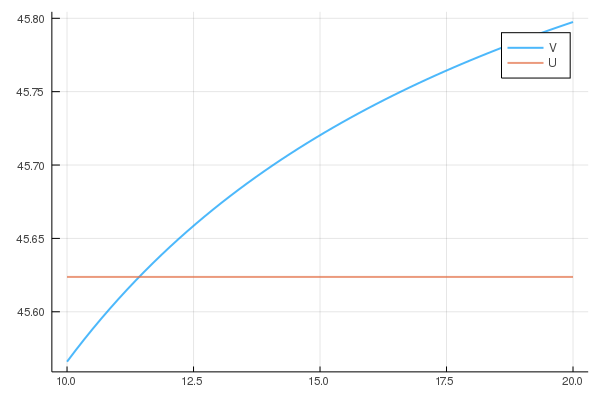

In [5]:
# confirguração de plotagem
gr(fmt=:png);

mcm = McCallModel()
@unpack V, U = solve_mccall_model(mcm)
U_vec = fill(U, length(mcm.w))

plot(mcm.w, [V U_vec], lw = 2, α = 0.7, label = ["V" "U"])

O valor $ V $ está aumentando pois quanto maior $ w $ gera um fluxo salarial mais alto, dependendo de permanecer empregado.

Nesse ponto, é natural perguntar como o modelo responderia se perturbássemos os parâmetros.

Esses cálculos, chamados de estática comparativa, são realizados na próxima seção.

## O Salário de Reserva

Uma vez que $ V $ e $ U $ são conhecidos, o agente pode usá-los para tomar decisões diante de uma determinada oferta salarial.

Se $ V(w) > U $, então o salário de está trabalhando $ w $ é preferível ao desemprego.

Se $ V(w) < U $, permanecer desempregado gerará maior valor de vida útil.

Suponha, em particular, que $ V $ cruza $ U $ (como na figura anterior).

Então, de modo que $ V $ esta aumentando, não há um único menor $ w $ no conjunto de salários possíveis, de modo que $ V(w) \geq U $.

Denotamos esse salário de $ \bar w $ e chamamos-o de salário de reserva.

O comportamento ideal para o trabalhador é caracterizado por $ \bar w $.

- se a oferta de salário $ w $ em mãos é maior ou igual a  $ \bar w $, então o trabalhador aceita. 
- se a oferta de salário $ w $ em mãos é menor ou igual a $ \bar w $, então o trabalhador rejeita. 


Se $ V(w) < U $ para todo $ w $, então a função retornará np.inf.

Vamos usá-lo para ver como o salário de reserva varia de acordo com os parâmetros.

Em cada instância abaixo, mostraremos uma figura e, em seguida, solicitaremos que você a reproduza nos exercícios.

### Salário de Reserva e Seguro Desemprego

Primeiro, vamos ver como $ \bar w $ varia de acordo com a remuneração do desemprego.

Na figura abaixo, usamos os parâmetros padrão na tupla McCallModel, além de c (que leva os valores dados no eixo horizontal).

<img src="https://julia.quantecon.org/dynamic_programming/_static/figures/mccall_resw_c.png" style="width:70%;">
  
Como esperado, uma maior remuneração do desemprego faz com que o trabalhador aguente salários mais altos.

Com efeito, o custo da busca contínua de emprego é reduzido.

### O Salário de Reserva e Desconto

Em seguida, vamos investigar como $ \bar w $ varia com a taxa de desconto.

A figura a seguir mostra o salário de reserva associado a diferentes valores de
$ \beta $

<img src="https://julia.quantecon.org/dynamic_programming/_static/figures/mccall_resw_beta.png" style="width:70%;">

  
Novamente, os resultados são intuitivos: mais trabalhadores pacientes aguentam salários mais altos.

### O Salário de Reserva e a Distribuição de Emprego

Finalmente, vamos ver como $ \bar w $ varia de acordo com a taxa de separação do trabalho $ \alpha $.

Quanto mais alto $ \alpha $ traduz a uma maior chance de um trabalhador enfrentar rescisão em cada período em que estiver empregado.

<img src="https://julia.quantecon.org/dynamic_programming/_static/figures/mccall_resw_alpha.png" style="width:70%;">
  
Mais uma vez, os resultados estão alinhados com a nossa intuição.

Se a taxa de separação for alta, o benefício de manter um salário mais alto cai.

Portanto, o salário de reserva é menor.

## Exercícios

### Exercício 1

Reproduza todas as figuras dos salários de reserva mostradas acima.

### Exercício 2

Plote o salário de reserva contra a taxa de oferta de trabalho $ \gamma $.

Use:

In [6]:
γ_vals = range(0.05,  0.95, length = 25)

0.05:0.0375:0.95

Interprete seus resultados.

## Soluções

### Exercício 1

Usando a função `solve_mccall_model` mencionada anteriomente na aula,
podemos criar uma matriz para os salários de reserva para diferentes valores de $ c $,
$ \beta $ e $ \alpha $ e plotar os resultados assim:

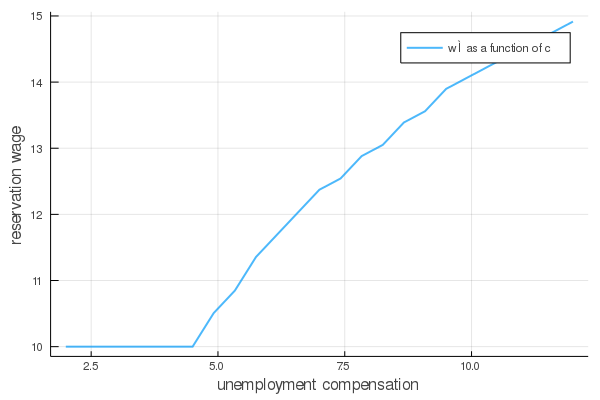

In [7]:
c_vals = range(2,  12, length = 25)

models = [McCallModel(c = cval) for cval in c_vals]
sols = solve_mccall_model.(models)
w̄_vals = [sol.w̄ for sol in sols]

plot(c_vals,
    w̄_vals,
    lw = 2,
    α = 0.7,
    xlabel = "unemployment compensation",
    ylabel = "reservation wage",
    label = "w̄ as a function of c")

Observe que poderíamos ter feito caso acima em um passo (o que seria importante se, por exemplo, o espaço do parâmetro fosse muito grande).

In [8]:
w̄_vals = [solve_mccall_model(McCallModel(c = cval)).w̄ for cval in c_vals];
# não aloca novas matrizes para modelos e soluções

### Exercício 2

Similar ao acima, podemos plotar $ \bar w $ contra $ \gamma $ da seguinte maneira:

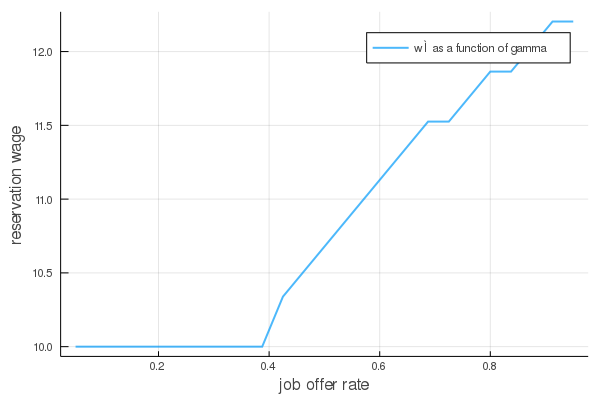

In [9]:
γ_vals = range(0.05,  0.95, length = 25)

models = [McCallModel(γ = γval) for γval in γ_vals]
sols = solve_mccall_model.(models)
w̄_vals = [sol.w̄ for sol in sols]

plot(γ_vals, w̄_vals, lw = 2, α = 0.7, xlabel = "job offer rate",
     ylabel = "reservation wage", label = "w̄ as a function of gamma")

Como esperado, o salário de reserva aumenta em $ \gamma $.

Isso é porque quanto maior $ \gamma $ se traduz em um ambiente de busca de emprego mais favorável.

Portanto, os trabalhadores estão menos dispostos a aceitar ofertas mais baixas.